# Gene sequence classification using LSTM

The goal of this project is to generate a model to classify a 60-element DNA sequence into the categories of IE,
EI or neither.

## Overall steps

The project consists of the following steps:

1. Get the data   
2. Prepare the data
3. Load and inspect the data
4. Split into training, validation, and test sets
5. Convert into sequence data required for LSTM
6. Import Keras libraries
7. Study the impact of number of LSTM units
8. Study the impact of dropout
9. Study the impact of recurrent dropout
10. Study the impact of optimization methods
11. Build the final model with the best sets of hyperparameters 
12. Test the performance on the unseen test data

## Get the data

Please download the data from the [UCI site](https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+(Splice-junction+Gene+Sequences))

Summarizing the description of the dataset there:
* This is a dataset of DNA sequences that define the boundaries between regions that are spliced out during protein creation (introns) or retained for protein creation (exons).
* There are 3 classes: boundaries between exon and intron sequences (EI), boundaries between intron and exon sequences (IE), or sequences that are neither.
* The dataset has 3190 examples of DNA sequences.
* Each sequence is 60 base-pairs long.

## Prepare the data

The gene sequence data is in the form of string of 60 characters and the labels consist of one of the three labels. The first step is to convert the input sequence and the labels into one-hot encoded sequences.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# function to one-hot-encode gene sequence
def one_hot_encode_sequence(seq_in, letters_dict):

    seq_in = seq_in.strip() # strip white space from beginning and end

    dataX = []

    dataX.append([list(letters_dict[char].values()) for char in seq_in])

    return dataX[0]

def char_array(seq_in):

    seq_in = seq_in.strip() # strip white space from beginning and end

    dataX = []

    dataX.append([char for char in seq_in])

    return dataX[0]

In [4]:
data = pd.read_csv('data/splice.data', sep = ',', index_col=False, header=None) # load the data
data.columns = ['label', 'donor', 'sequence'] # set the column names
del data['donor'] # delete the donor column

# convert each 60-letter sequence to one-hot encoded-number sequence
all_letters = data['sequence'].apply(lambda x: char_array(x))
all_letters = np.hstack(all_letters.values)
unique_letters = np.unique(all_letters)
one_hot_encoded_letters = pd.get_dummies(unique_letters)
letters_dict = one_hot_encoded_letters.to_dict()

data['seq_num'] = data['sequence'].apply(lambda x: one_hot_encode_sequence(x, letters_dict))
print(data.head())

# one-hot encode the labels and store them in a dictionary
all_labels = np.hstack(data['label'].values)
unique_labels = np.unique(all_labels)
one_hot_encoded_labels = pd.get_dummies(unique_labels)
labels_dict = one_hot_encoded_labels.to_dict()

x_coll = []
y_coll = []
for i in range(0, len(data)):
    x = data['seq_num'][i]
    x_coll.append(x)

    y = list(labels_dict[data['label'][i]].values())
    y_coll.append(y)

np.savez('data/gene_sequence_one_hot_data.npz', x_coll, y_coll)

  label                                           sequence  \
0    EI                 CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...   
1    EI                 AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...   
2    EI                 GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...   
3    EI                GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...   
4    EI               GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...   

                                             seq_num  
0  [[0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...  
1  [[1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ...  
2  [[0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, ...  
3  [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, ...  
4  [[0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...  


## Load and inspect the data

In [5]:
data = np.load('data/gene_sequence_one_hot_data.npz')

X,y = data

X = data[X].astype('float32')
y = data[y].astype('float32')

print(X[0], y[0])

[[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0

## Split into training, validation, and test sets

In [6]:
from sklearn.model_selection import train_test_split

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.111, random_state=42)

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_valid.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (2552, 60, 8)
Validation data shape:  (319, 60, 8)
Test data shape:  (319, 60, 8)


## Convert into sequence data required for LSTM

In [7]:
seq_length = 60
# reshape X to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], seq_length, 8)) # Number of unique letters = one hot encoded length = 8
X_valid = np.reshape(X_valid, (X_valid.shape[0], seq_length, 8))
X_test = np.reshape(X_test, (X_test.shape[0], seq_length, 8))

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_valid.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (2552, 60, 8)
Validation data shape:  (319, 60, 8)
Test data shape:  (319, 60, 8)


## Import Keras libraries

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import keras.backend as K

## Study the impact of number of LSTM units 

Text(0, 0.5, 'Accuracy')

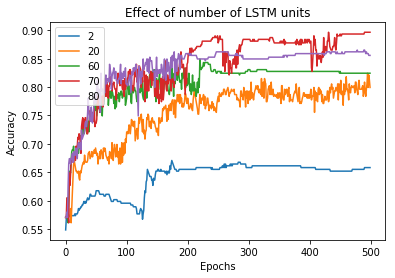

In [27]:
batch_size = 128
epochs = 500

K.clear_session()
model = Sequential()
model.add(LSTM(2, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_a = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_b = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_c = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_d = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_e = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

plt.plot(h_a.history['val_acc'])
plt.plot(h_b.history['val_acc'])
plt.plot(h_c.history['val_acc'])
plt.plot(h_d.history['val_acc'])
plt.plot(h_e.history['val_acc'])
plt.legend(['2', '20', '60', '70', '80'])
plt.title('Effect of number of LSTM units')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Study the impact of the dropout

Text(0, 0.5, 'Accuracy')

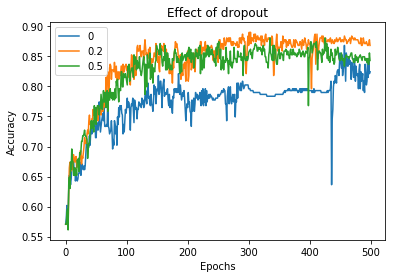

In [28]:
batch_size = 128
epochs = 500

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_a = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_b = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_c = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

plt.plot(h_a.history['val_acc'])
plt.plot(h_b.history['val_acc'])
plt.plot(h_c.history['val_acc'])
plt.legend(['0', '0.2', '0.5'])
plt.title('Effect of dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Study the impact of the batch size

Text(0, 0.5, 'Accuracy')

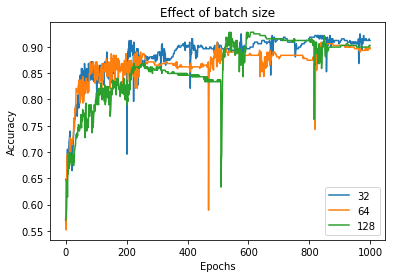

In [29]:
epochs = 500

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_a = model.fit(X_train, y_train, batch_size=32, epochs = 1000, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_b = model.fit(X_train, y_train, batch_size=64, epochs = 1000, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_c = model.fit(X_train, y_train, batch_size=128, epochs = 1000, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

plt.plot(h_a.history['val_acc'])
plt.plot(h_b.history['val_acc'])
plt.plot(h_c.history['val_acc'])
plt.legend(['32', '64', '128'])
plt.title('Effect of batch size')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Study the impact of recurrent dropout

Text(0, 0.5, 'Accuracy')

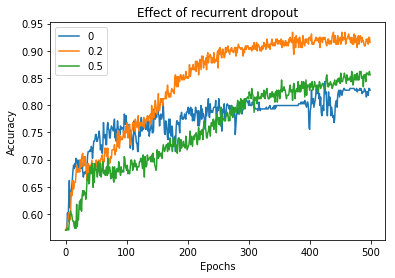

In [30]:
batch_size = 128
epochs = 500

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_a = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_b = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_c = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

plt.plot(h_a.history['val_acc'])
plt.plot(h_b.history['val_acc'])
plt.plot(h_c.history['val_acc'])
plt.legend(['0', '0.2', '0.5'])
plt.title('Effect of recurrent dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Study the impact of optimization technique

Text(0, 0.5, 'Accuracy')

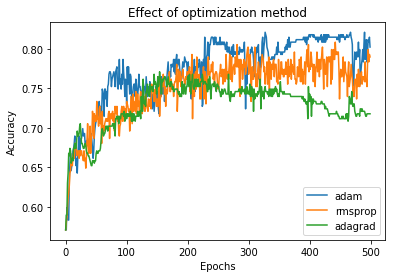

In [31]:
batch_size = 128
epochs = 500

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h_a = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
h_b = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

K.clear_session()
model = Sequential()
model.add(LSTM(60, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
h_c = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_valid, y_valid), shuffle=False, verbose=0)

plt.plot(h_a.history['val_acc'])
plt.plot(h_b.history['val_acc'])
plt.plot(h_c.history['val_acc'])
plt.legend(['adam', 'rmsprop', 'adagrad'])
plt.title('Effect of optimization method')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Performance of the final model on the test data

Text(0, 0.5, 'Accuracy')

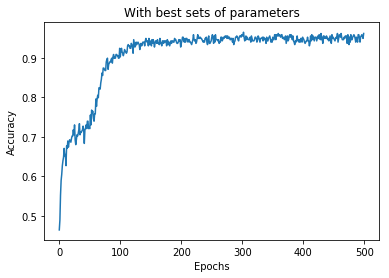

In [36]:
epochs = 500
batch_size = 32

K.clear_session()
model = Sequential()
model.add(LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
h = model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test, y_test), shuffle=False, verbose=0)

plt.plot(h.history['val_acc'])
plt.title('With best sets of parameters')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [61]:
y_pred = model.predict_classes(X_test).astype(int)
y_true = np.argmax(y_test, axis=1)

In [62]:
class_names = ['EL', 'IE', 'N']

Confusion matrix, without normalization
[[ 94   0   5]
 [  0  70   3]
 [  2   2 143]]
Normalized confusion matrix
[[0.95 0.   0.05]
 [0.   0.96 0.04]
 [0.01 0.01 0.97]]


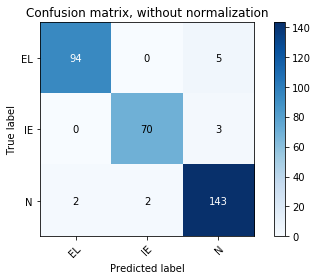

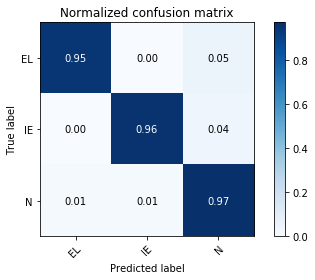

In [74]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()